In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout

C:\Users\uchei\anaconda3\anaconda3.8\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
classes = pd.read_csv(r"C:/Users/uchei/OneDrive/Desktop/Gozie/planet/planet/train_classes.csv")

In [3]:
classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
#Creating a list of all labels contained in the dataframe
labels = set()
for i in range(len(classes)):
    tags = classes['tags'][i].split(' ')
    labels.update(tags)
    
    
label_list = list(labels)
label_list

['water',
 'cloudy',
 'clear',
 'haze',
 'primary',
 'road',
 'cultivation',
 'conventional_mine',
 'slash_burn',
 'blooming',
 'agriculture',
 'selective_logging',
 'bare_ground',
 'blow_down',
 'partly_cloudy',
 'artisinal_mine',
 'habitation']

In [5]:
# Add onehot features for every label in the list
for label in label_list:
    classes[label] = classes['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
    
# adding '.jpg' extension to 'image_name'
def append_ext(fn):
    return fn+".jpg"

classes["image_name"]=classes["image_name"].apply(append_ext)

classes.head()

,image_name,tags,water,cloudy,clear,haze,primary,road,cultivation,conventional_mine,slash_burn,blooming,agriculture,selective_logging,bare_ground,blow_down,partly_cloudy,artisinal_mine,habitation
0,train_0.jpg,haze primary,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,train_2.jpg,clear primary,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1


In [6]:
#Creating separate list to store columns
image_types = list(classes.columns[2:])
image_types

['water',
 'cloudy',
 'clear',
 'haze',
 'primary',
 'road',
 'cultivation',
 'conventional_mine',
 'slash_burn',
 'blooming',
 'agriculture',
 'selective_logging',
 'bare_ground',
 'blow_down',
 'partly_cloudy',
 'artisinal_mine',
 'habitation']

In [7]:
assert len(classes['image_name'].unique()) == classes.shape[0]

In [10]:
#loading all training data
rootdir = 'C:/Users/uchei/OneDrive/Desktop/Gozie/planet/planet/train-jpg'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        train1 = cv2.imread(os.path.join(subdir, file))

In [11]:
#Generating images and augmenting at the same time
train_image_generator =ImageDataGenerator(rescale=1/255,validation_split=0.2,
                                          rotation_range = 90, shear_range = 0.2, zoom_range = 0.2,
                                          width_shift_range = 0.2, height_shift_range = 0.2,
                                          horizontal_flip = True)

# using a validation split here

# generating the 80% training image data
train_generator = train_image_generator.flow_from_dataframe(dataframe=classes,
        directory=rootdir, x_col='image_name', y_col=image_types,
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=32, subset='training')

# generating the 20% validation image data
validation_generator = train_image_generator.flow_from_dataframe(dataframe=classes,
        directory=rootdir, x_col='image_name', y_col=image_types,
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=32, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [13]:
train_step_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
val_step_size = int(np.ceil(validation_generator.samples / train_generator.batch_size))

In [14]:
#defining accuracy function
def fbeta(y_true , y_pred, beta=2, epsilon=1e-4):
    squared_beta = beta**2

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.2)), tf.float32)
        
    tp = tf.reduce_sum(y_true * y_pred, axis=1)
    fp = tf.reduce_sum(y_pred, axis=1) - tp
    fn = tf.reduce_sum(y_true, axis=1) - tp
    
    p = tp/(tp+fp+epsilon)   #precision
    r = tp/(tp+fn+epsilon)   #recall
    
    fb = (1+squared_beta)*p*r / (squared_beta*p + r + epsilon)
    return fb

In [15]:
#Creating checkpoints to prevent model overfitting
checkpoint = ModelCheckpoint(filepath='weight_model.hdf5',monitor='val_fbeta', 
                             save_best_only=True, save_weights_only=True, mode='max', verbose = 1)
early = EarlyStopping(monitor='val_fbeta', min_delta=0, patience=10, verbose=1, mode='max')

In [16]:
#Defining training parameters
planet_model = Sequential([
    Conv2D(32, kernel_size = 3, kernel_regularizer = l2(0.0005), strides = (1,1), padding = 'valid', activation = 'relu',input_shape = (128, 128, 3)),
    MaxPooling2D(pool_size = (2,2)),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(17, activation = 'sigmoid')
])
planet_model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate=0.0001),metrics = [fbeta])

In [17]:
#training the model
history = planet_model.fit(train_generator,
                             epochs = 20,
                             steps_per_epoch = train_step_size,
                             validation_data = validation_generator,
                             validation_steps = val_step_size,
                             callbacks = [checkpoint, early])

Epoch 1/20
1012/1012 [==============================] - ETA: 0s - loss: 0.2495 - fbeta: 0.7829
Epoch 00001: val_fbeta improved from -inf to 0.80267, saving model to weight_model.hdf5
1012/1012 [==============================] - 723s 713ms/step - loss: 0.2495 - fbeta: 0.7829 - val_loss: 0.2227 - val_fbeta: 0.8027
Epoch 2/20
1012/1012 [==============================] - ETA: 0s - loss: 0.2045 - fbeta: 0.8148
Epoch 00002: val_fbeta improved from 0.80267 to 0.81291, saving model to weight_model.hdf5
1012/1012 [==============================] - 711s 703ms/step - loss: 0.2045 - fbeta: 0.8148 - val_loss: 0.1980 - val_fbeta: 0.8129
Epoch 3/20
1012/1012 [==============================] - ETA: 0s - loss: 0.1784 - fbeta: 0.8320
Epoch 00003: val_fbeta improved from 0.81291 to 0.84248, saving model to weight_model.hdf5
1012/1012 [==============================] - 708s 700ms/step - loss: 0.1784 - fbeta: 0.8320 - val_loss: 0.1682 - val_fbeta: 0.8425
Epoch 4/20
1012/1012 [==============================

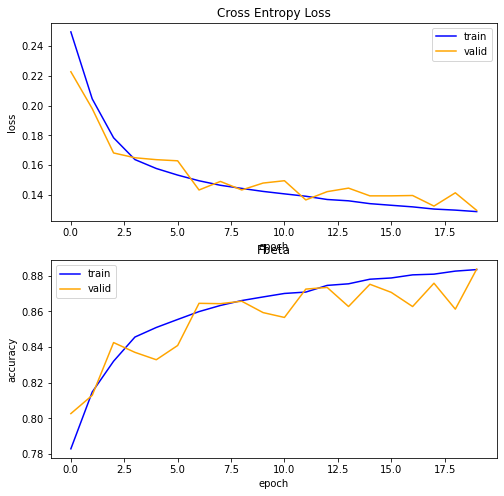

In [18]:
plt.figure(1, figsize = (8,8)) 
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

# plot accuracy
plt.subplot(212)
plt.title('Fbeta')
plt.plot(history.history['fbeta'], color='blue', label='train')
plt.plot(history.history['val_fbeta'], color='orange', label='test')
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

In [19]:
test_loss, test_accuracy = planet_model.evaluate(validation_generator)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

253/253 [==============================] - 76s 301ms/step - loss: 0.1303 - fbeta: 0.8843
Test loss: 0.13029499351978302
Test accuracy: 0.8842754364013672


In [20]:
#Taking the format for submission
sam_sub = pd.read_csv(r"C:/Users/uchei/OneDrive/Desktop/Gozie/planet/planet/sample_submission.csv")
sam_sub['image_name'] = sam_sub['image_name'].apply(lambda i: '{}.jpg'.format(i))
test1 = sam_sub.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
testdir = 'C:/Users/uchei/OneDrive/Desktop/Gozie/planet/planet/test-jpg'

In [22]:
test_image_generator1 = ImageDataGenerator(rescale=1/255)


test_generator1 = test_image_generator1.flow_from_dataframe(dataframe=test1,
            directory=testdir, x_col='image_name', y_col=None,
            batch_size=32, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size 
test_step_size1 = int(np.ceil(test_generator1.samples / test_generator1.batch_size))

Found 40669 validated image filenames.


In [23]:
test_generator1.reset() 

# prediction for test1
prediction1 = planet_model.predict(test_generator1, steps=test_step_size1, verbose=1) 

1271/1271 [==============================] - 285s 224ms/step


In [25]:
testdir1 = 'C:/Users/uchei/OneDrive/Desktop/Gozie/test-jpg-additional/test-jpg-additional'
# selecting the remaining image_name from the sample_submission to generate image data for test-additional.jpg
test2 = sam_sub.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [26]:
test_image_generator2 = ImageDataGenerator(rescale=1/255)


test_generator2 = test_image_generator2.flow_from_dataframe(dataframe=test2,
            directory=testdir1, x_col='image_name', y_col=None,
            batch_size=32, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size 
test_step_size2 = int(np.ceil(test_generator2.samples / test_generator2.batch_size))

Found 20522 validated image filenames.


In [27]:
# reseting the generator to avoid shuffling
test_generator2.reset() 

# prediction for test2
prediction2 = planet_model.predict(test_generator2, steps=test_step_size2, verbose=1)

642/642 [==============================] - 135s 210ms/step


In [28]:
# obtaining the filenames from test_generator
filenames1 = test_generator1.filenames 
        
# converting the predictions of the first 40669 to tag names
predict_tags1 = pd.DataFrame(prediction1)
#Choosing predicted values over 20% to add to the tag column
predict_tags1 = predict_tags1.apply(lambda x: ' '.join(np.array(label_list)[x > 0.2]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result_df1 = pd.DataFrame({'image_name': filenames1, 'tags': predict_tags1})
result_df1.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,clear primary partly_cloudy
4,test_4.jpg,cloudy primary partly_cloudy


In [29]:
# obtaining the filenames from test_generator2
filenames2 = test_generator2.filenames 
        
# converting the predictions of the remaining images to tag names
predict_tags2 = pd.DataFrame(prediction2)
predict_tags2 = predict_tags2.apply(lambda x: ' '.join(np.array(label_list)[x > 0.2]), axis=1)

# converting the predictions of the remaining to a dataframe
result_df2 = pd.DataFrame({'image_name': filenames2, 'tags': predict_tags2})

In [30]:
# concatenating the predictions of test.jpg and test-additional.jpg into a single dataframe
final_result = pd.concat([result_df1, result_df2]) 
    
final_result = final_result.reset_index().drop('index', axis=1)

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,clear primary partly_cloudy
4,test_4.jpg,cloudy primary partly_cloudy


In [31]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sam_sub['image_name'] == final_result['image_name']) == 61191
# removing the .jpg extension from 'image_name' column
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,primary partly_cloudy
3,test_3,clear primary partly_cloudy
4,test_4,cloudy primary partly_cloudy


In [107]:
planet_model.save('model3.hdf5')